In [3]:
import random
import torch

In [4]:
import d2l
from d2l import torch as d2l

In [5]:
hg_wells = d2l.read_time_machine()

In [6]:
hg_wells[34:39]

['that is all right said the psychologist',
 '',
 'nor having only length breadth and thickness can a cube have a',
 'real existence',
 '']

In [7]:
def tokenize(lines, type='word'):
    if type=='word':
        return [line.split() for line in lines]
    elif type=='char':
        return [list(line) for line in lines]
    else:
        return 'unknown type of token. Check definition.'

In [8]:
tokens = tokenize(hg_wells)


In [9]:
tokens[15:17][:3]

[['luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'roams',
  'gracefully'],
 ['free',
  'of',
  'the',
  'trammels',
  'of',
  'precision',
  'and',
  'he',
  'put',
  'it',
  'to',
  'us',
  'in',
  'this']]

In [10]:
char_tokens = tokenize(hg_wells, type='char')

char_tokens[15][:5]

['l', 'u', 'x', 'u', 'r']

In [11]:
corpus  = [token for line in tokens for token in line]

In [12]:
corpus[:5]

['the', 'time', 'machine', 'by', 'h']

In [13]:
import collections

def count_corpus(tokens):
    if len(tokens)==0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [14]:
class Vocab:
    def __init__(self,tokens=None, min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        self.counter = count_corpus(tokens)
        self._token_freqs = sorted(self.counter.items(), key=lambda x: x[1], reverse=True)
        
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_index = {token : idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.idx_to_token:
                self.idx_to_token.append(token)
                self.token_to_index[token] = len(self.idx_to_token)-1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        #recursively tries to get the individual item
        if not isinstance(tokens,(list, tuple)):
            #print(self.token_to_index.get(tokens, self.unk))
            return self.token_to_index.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def totokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.totokens(index) for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [15]:
vocab = Vocab(tokens)

#looking through functions in vocab
freq_dict = sorted(vocab.counter.items(), key=lambda x: x[1], reverse=True)[:5]

print(freq_dict)

idx_to_token = []

for token, freq in freq_dict:
    idx_to_token.append(token)

print(idx_to_token)

vocab['the'] # should call __getitem__

vocab[idx_to_token]

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816)]
['the', 'i', 'and', 'of', 'a']


[1, 2, 3, 4, 5]

In [16]:
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [17]:
#same thing
#vocab = d2l.Vocab(corpus)

In [18]:
#vocab.token_freqs[:10]

As we can see, the most popular words are actually quite boring to look at. They are often referred
to as stop words and thus filtered out. Nonetheless, they still carry meaning and we will still use
them. Besides, it is quite clear that the word frequency decays rather rapidly. The 10th most frequent word is less than 1/5 as common as the most popular one. To get a better idea, we plot the
figure of the word frequency.

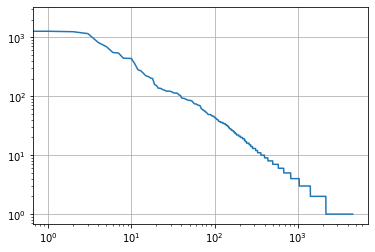

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]

import matplotlib.pyplot as plt

plt.plot(freqs)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

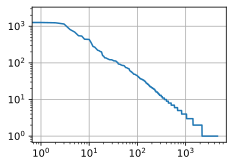

In [20]:
#same as
d2l.plot(freqs, xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a welldefined way. After dealing with the first few words as exceptions, all the remaining words roughly
follow a straight line on a log-log plot. This means that words satisfy Zipf’s law, which states that
the frequency ni of the i
th most frequent word is:

ni ∝ 1/i^a(8.3.7)
which is equivalent to
log ni = −α log i + c, (8.3.8)

where α is the exponent that characterizes the distribution and c is a constant. This should already
give us pause if we want to model words by counting statistics and smoothing. After all, we will
significantly overestimate the frequency of the tail, also known as the infrequent words. But what
about the other word combinations, such as bigrams, trigrams, and beyond?

In [21]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]

bigram_vocab = Vocab(bigram_tokens)

In [22]:
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [23]:
bigram_freq = [freq for token, freq in bigram_vocab.token_freqs]

def plot_log(freq):
    plt.plot(freq)
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')



In [24]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]

trigram_vocab = Vocab(trigram_tokens)

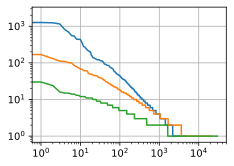

In [25]:
trigram_freq = [freq for token, freq in trigram_vocab.token_freqs]

plot_log(freqs)
plot_log(bigram_freq)
plot_log(trigram_freq)
plt.show()

### Random sampling

In [26]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)
    
    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
    

### looking at what is happening here

In [27]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [13, 14, 15, 16, 17]])
X:  tensor([[17, 18, 19, 20, 21],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [28, 29, 30, 31, 32]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]])


In [28]:
my_seq_corpus = my_seq[random.randint(0, 4):]# numsteps = 5
my_seq_corpus[:5], len(my_seq_corpus)

([2, 3, 4, 5, 6], 33)

In [29]:
random.randint(0,4)

3

In [30]:
my_seq[:5]

[0, 1, 2, 3, 4]

In [31]:
num_subseq = (len(my_seq_corpus)-1)//5

In [32]:
num_subseq

6

In [33]:
initial_indices = list(range(0, num_subseq * 5, 5))
initial_indices

[0, 5, 10, 15, 20, 25]

In [34]:
random.shuffle(initial_indices)
initial_indices

[10, 15, 20, 0, 25, 5]

In [35]:
pos = 4
num_steps = 5
my_seq_corpus[pos:pos+num_steps]

[6, 7, 8, 9, 10]

In [36]:
num_batches = num_subseq // 2 #2 is batch size


In [37]:
def yielder():
    batch_size=2
    for i in range(0, batch_size * num_batches, batch_size ):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        print("initial_indices: ", initial_indices_per_batch)
        X = [my_seq_corpus[j:j+num_steps] for j in initial_indices_per_batch]
        Y = [my_seq_corpus[j+1:j+1+num_steps] for j in initial_indices_per_batch]
        yield X, Y

In [38]:
for x, y in yielder():
    print(x)
    print(y)
    

initial_indices:  [10, 15]
[[12, 13, 14, 15, 16], [17, 18, 19, 20, 21]]
[[13, 14, 15, 16, 17], [18, 19, 20, 21, 22]]
initial_indices:  [20, 0]
[[22, 23, 24, 25, 26], [2, 3, 4, 5, 6]]
[[23, 24, 25, 26, 27], [3, 4, 5, 6, 7]]
initial_indices:  [25, 5]
[[27, 28, 29, 30, 31], [7, 8, 9, 10, 11]]
[[28, 29, 30, 31, 32], [8, 9, 10, 11, 12]]


### sequential data iteration

In [39]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size ) * batch_size
    Xs = torch.tensor(corpus[offset:offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1]//num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X,Y

In [40]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(X)
    print(Y)

tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]])
tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]])
tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]])
tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [45]:
offset = 3
batch_size=2
num_tokens = (len(my_seq) -offset -1) //batch_size
num_tokens *= batch_size
num_tokens

30

In [47]:
Xs = torch.tensor(my_seq[offset:offset+num_tokens])
Ys = torch.tensor(my_seq[offset+1:offset+1+num_tokens])

Xs ,Ys

(tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]))

In [48]:
Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
Xs, Ys

(tensor([[ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
         [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]))

In [51]:
Xs.shape[1] // num_steps

3

In [52]:
range(0, num_steps * num_batches, num_steps )

range(0, 15, 5)

In [54]:
class SeqDataLoader():
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.iter_function = seq_data_iter_random()
        else :
            self.iter_function = seq_data_iter_sequential
            
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.iter_function(self.corpus, self.batch_size, self.num_stpes)

In [55]:
def load_data_time_machine(batch_size=2, num_steps=5, use_random_iter=False,max_tokens=1000 ):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab
    

In [56]:
data_iter, vocab = load_data_time_machine()

In [58]:
data_iter, vocab

(<__main__.SeqDataLoader at 0x2164dac9d90>, <d2l.torch.Vocab at 0x2164dae3370>)

### Exercises

1. Suppose there are 100, 000 words in the training dataset. How much word frequency and
multi-word adjacent frequency does a four-gram need to store?
    Dont get the question
    
2. How would you model a dialogue?
    Dont have an idea what it is prodding us to do.
    
3. Estimate the exponent of Zipfʼs law for unigrams, bigrams, and trigrams.
    okay.two decaying functions. Not able to make unigram.
    
4. What other methods can you think of for reading long sequence data?
    maybe storing them in a dict,for oft repeated words memory can be saved

5. Consider the random offset that we use for reading long sequences.
    1. Why is it a good idea to have a random offset?
        for the randomness
    2. Does it really lead to a perfectly uniform distribution over the sequences on the document?
        I dont know how to check
    3. What would you have to do to make things even more uniform?
        Would maybe take words based on some distribution.
        
6. If we want a sequence example to be a complete sentence, what kind of problem does this
introduce in minibatch sampling? How can we fix the problem?
    All the sentences have different number of words so we wont be able to get a minibatch tha tis uniform.
    we can pad data.

In [64]:
tokens = tokenize(hg_wells)
vocab = Vocab(tokens)

In [65]:
vocab.token_freqs[0]

('the', 2261)

In [70]:
import math
try:
    single_freq_exp = [math.exp(freq) for token, freq in vocab.token_freqs]
except Exception as e:
    print(e)
    
bigram_freqs_exp = [math.exp(freq) for token, freq in bigram_vocab.token_freqs]
trigram_freqs_exp = [math.exp(freq) for token, freq in trigram_vocab.token_freqs]

math range error


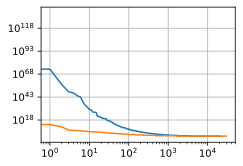

In [71]:
#plot_log(freqs)
plot_log(bigram_freqs_exp)
plot_log(trigram_freqs_exp)
plt.show()